# Config

In [2]:
import json
import torch
import numpy as np
import mdtraj as md
import nglview as nv

import openmm as mm
import openmm.unit as unit
from openmm import app

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

PHI_ANGLE = [4, 6, 8, 14]
PSI_ANGLE = [6, 8, 14, 16]
ALANINE_HEAVY_ATOM_IDX = [1, 4, 5, 6, 8, 10, 14, 15, 16, 18]

In [5]:
def compute_dihedral(positions):
    """http://stackoverflow.com/q/20305272/1128289"""
    def dihedral(p):
        if not isinstance(p, np.ndarray):
            p = p.numpy()
        b = p[:-1] - p[1:]
        b[0] *= -1
        v = np.array([v - (v.dot(b[1]) / b[1].dot(b[1])) * b[1] for v in [b[0], b[2]]])
        
        # Normalize vectors
        v /= np.sqrt(np.einsum('...i,...i', v, v)).reshape(-1, 1)
        b1 = b[1] / np.linalg.norm(b[1])
        x = np.dot(v[0], v[1])
        m = np.cross(v[0], b1)
        y = np.dot(m, v[1])
        
        return np.arctan2(y, x)
    
    return np.array(list(map(dihedral, positions)))

In [6]:
n_particles = 22
n_dimensions = 3
scaling = 10
dim = n_particles * n_dimensions

# TBG dataset

In [21]:
current_xyz_tbg_loaded = torch.load("../dataset/alanine/300.0/tbg-10n-v2/current-xyz.pt")
print(current_xyz_tbg_loaded.shape)

torch.Size([200000, 22, 3])


## Original dataset

In [33]:
current_xyz = torch.load("../dataset/alanine/300.0/timelag-10n-v1/xyz-aligned.pt")
print(current_xyz.shape)
phi = compute_dihedral(current_xyz[:, PHI_ANGLE])
psi = compute_dihedral(current_xyz[:, PSI_ANGLE])

torch.Size([10000, 22, 3])


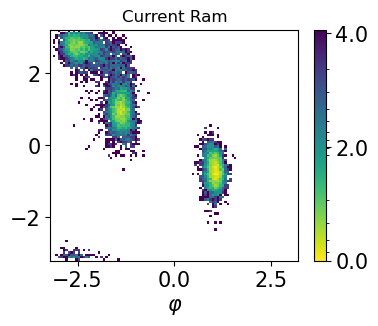

In [34]:
fig, ax = plt.subplots(figsize=(4, 3))
plot_range = [-3.2, 3.2]
h, x_bins, y_bins, im = ax.hist2d(phi, psi, 100, norm=LogNorm(), range=[plot_range,plot_range],rasterized=True)
ticks = np.array([np.exp(-6)*h.max(), np.exp(-4.0)*h.max(),np.exp(-2)*h.max(), h.max()])
ax.set_title("Current Ram")
ax.set_xlabel(r"$\varphi$", fontsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
cbar = fig.colorbar(im, ticks=ticks)
cbar.ax.set_yticklabels([6.0,4.0,2.0,0.0], fontsize=15)
cbar.ax.invert_yaxis()

In [35]:
timelag_xyz = torch.load("../dataset/alanine/300.0/timelag-10n-v1/xyz-aligned.pt")
print(timelag_xyz.shape)
phi = compute_dihedral(timelag_xyz[:, PHI_ANGLE])
psi = compute_dihedral(timelag_xyz[:, PSI_ANGLE])

torch.Size([10000, 22, 3])


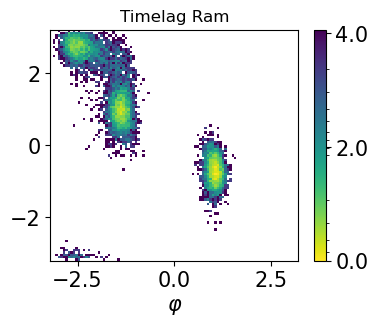

In [36]:
fig, ax = plt.subplots(figsize=(4, 3))
plot_range = [-3.2, 3.2]
h, x_bins, y_bins, im = ax.hist2d(phi, psi, 100, norm=LogNorm(), range=[plot_range,plot_range],rasterized=True)
ticks = np.array([np.exp(-6)*h.max(), np.exp(-4.0)*h.max(),np.exp(-2)*h.max(), h.max()])
ax.set_title("Timelag Ram")
ax.set_xlabel(r"$\varphi$", fontsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
cbar = fig.colorbar(im, ticks=ticks)
cbar.ax.set_yticklabels([6.0,4.0,2.0,0.0], fontsize=15)
cbar.ax.invert_yaxis()

## XYZ build

In [82]:
current_xyz_tbg = current_xyz.clone()
current_xyz_tbg[:, [0, 1]] = current_xyz_tbg[:, [1, 0]]
print(current_xyz[0, :3])
print(current_xyz_tbg[0, :3])

tensor([[1.8591, 0.3760, 1.9517],
        [1.8739, 0.3865, 2.0592],
        [1.9753, 0.3926, 2.0986]])
tensor([[1.8739, 0.3865, 2.0592],
        [1.8591, 0.3760, 1.9517],
        [1.9753, 0.3926, 2.0986]])


In [83]:
current_xyz_tbg_mean = current_xyz_tbg.mean()
current_xyz_tbg_std = current_xyz_tbg.std()
print(current_xyz_tbg_mean)
print(current_xyz_tbg_std)
current_xyz_tbg = (current_xyz_tbg - current_xyz_tbg.mean()) / current_xyz_tbg.std()

tensor(1.5508)
tensor(0.6695)


In [84]:
current_xyz_tbg = current_xyz_tbg.reshape(-1, n_particles * n_dimensions)
print(current_xyz_tbg.shape)
torch.save(current_xyz_tbg, "../dataset/alanine/300.0/tbg-10n/current-xyz.pt")
json.dump({
	"mean": current_xyz_tbg_mean.item(),
	"std": current_xyz_tbg_std.item()
}, open("../dataset/alanine/300.0/tbg-10n/current-xyz.json", "w"))

torch.Size([10000, 66])


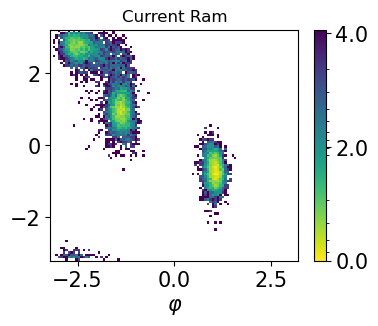

In [86]:

current_xyz_tbg_loaded = torch.load("../dataset/alanine/300.0/tbg-10n/current-xyz.pt")
current_xyz_tbg_loaded = current_xyz_tbg_loaded.reshape(-1, n_particles, n_dimensions)
phi = compute_dihedral(current_xyz_tbg_loaded[:, PHI_ANGLE])
psi = compute_dihedral(current_xyz_tbg_loaded[:, PSI_ANGLE])

fig, ax = plt.subplots(figsize=(4, 3))
plot_range = [-3.2, 3.2]
h, x_bins, y_bins, im = ax.hist2d(phi, psi, 100, norm=LogNorm(), range=[plot_range,plot_range],rasterized=True)
ticks = np.array([np.exp(-6)*h.max(), np.exp(-4.0)*h.max(),np.exp(-2)*h.max(), h.max()])
ax.set_title("Current Ram")
ax.set_xlabel(r"$\varphi$", fontsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
cbar = fig.colorbar(im, ticks=ticks)
cbar.ax.set_yticklabels([6.0,4.0,2.0,0.0], fontsize=15)
cbar.ax.invert_yaxis()

In [87]:
timelag_xyz_tbg = timelag_xyz.clone()
timelag_xyz_tbg[:, [0, 1]] = timelag_xyz_tbg[:, [1, 0]]
print(timelag_xyz[0, :3])
print(timelag_xyz_tbg[0, :3])

tensor([[1.8591, 0.3760, 1.9517],
        [1.8739, 0.3865, 2.0592],
        [1.9753, 0.3926, 2.0986]])
tensor([[1.8739, 0.3865, 2.0592],
        [1.8591, 0.3760, 1.9517],
        [1.9753, 0.3926, 2.0986]])


In [88]:
timelag_xyz_tbg_mean = timelag_xyz_tbg.mean()
timelag_xyz_tbg_std = timelag_xyz_tbg.std()
print(timelag_xyz_tbg_mean)
print(timelag_xyz_tbg_std)
timelag_xyz_tbg = (timelag_xyz_tbg - timelag_xyz_tbg.mean()) / timelag_xyz_tbg.std()

tensor(1.5508)
tensor(0.6695)


In [89]:
timelag_xyz_tbg = timelag_xyz_tbg.reshape(-1, n_particles * n_dimensions)
print(timelag_xyz_tbg.shape)
torch.save(timelag_xyz_tbg, "../dataset/alanine/300.0/tbg-10n/timelag-xyz.pt")
json.dump({
	"mean": timelag_xyz_tbg_mean.item(),
	"std": timelag_xyz_tbg_std.item()
}, open("../dataset/alanine/300.0/tbg-10n/timelag-xyz.json", "w"))

torch.Size([10000, 66])


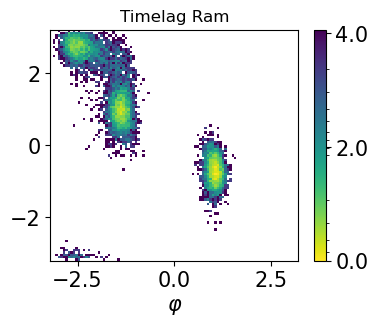

In [90]:
timelag_xyz_tbg_loaded = torch.load("../dataset/alanine/300.0/tbg-10n/timelag-xyz.pt")
timelag_xyz_tbg_loaded = timelag_xyz_tbg_loaded.reshape(-1, n_particles, n_dimensions)
phi = compute_dihedral(timelag_xyz_tbg_loaded[:, PHI_ANGLE])
psi = compute_dihedral(timelag_xyz_tbg_loaded[:, PSI_ANGLE])

fig, ax = plt.subplots(figsize=(4, 3))
plot_range = [-3.2, 3.2]
h, x_bins, y_bins, im = ax.hist2d(phi, psi, 100, norm=LogNorm(), range=[plot_range,plot_range],rasterized=True)
ticks = np.array([np.exp(-6)*h.max(), np.exp(-4.0)*h.max(),np.exp(-2)*h.max(), h.max()])
ax.set_title("Timelag Ram")
ax.set_xlabel(r"$\varphi$", fontsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
cbar = fig.colorbar(im, ticks=ticks)
cbar.ax.set_yticklabels([6.0,4.0,2.0,0.0], fontsize=15)
cbar.ax.invert_yaxis()

## Heavy atom distance build

In [91]:
ALANINE_HEAVY_ATOM_IDX_TBG = [0, 4, 5, 6, 8, 10, 14, 15, 16, 18]

def coordinate2distance(
    positions
):
    '''
        Compute pairwise distances between heavy atoms of alanine
        Args:
            positions (torch.Tensor): Positions of atoms (n_samples, *)
    '''
    
    distance_list = []
    
    for position in tqdm(positions):
        position = position.reshape(-1, 3)
        heavy_atom_position = position[ALANINE_HEAVY_ATOM_IDX_TBG]
        num_heavy_atoms = len(heavy_atom_position)
        distance = []
        for i in range(num_heavy_atoms):
            for j in range(i+1, num_heavy_atoms):
                distance.append(torch.norm(heavy_atom_position[i] - heavy_atom_position[j]))
        distance = torch.stack(distance)
        distance_list.append(distance)
    
    return torch.stack(distance_list)

In [92]:
current_xyz_tbg_loaded = current_xyz_tbg_loaded.reshape(-1, n_particles, n_dimensions)
current_distance_tbg = coordinate2distance(current_xyz_tbg_loaded)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [93]:
print(current_distance_tbg.shape)
torch.save(current_distance_tbg, "../dataset/alanine/300.0/tbg-10n/current-distance.pt")

torch.Size([10000, 45])


## Label

In [7]:
current_xyz_tbg_loaded = torch.load("../dataset/alanine/300.0/tbg-10n-v2/current-xyz.pt")
current_xyz_tbg_loaded = current_xyz_tbg_loaded.reshape(-1, n_particles, n_dimensions)
phi = compute_dihedral(current_xyz_tbg_loaded[:, PHI_ANGLE].numpy())
psi = compute_dihedral(current_xyz_tbg_loaded[:, PSI_ANGLE].numpy())
print(phi.shape, psi.shape)

(200000,) (200000,)


In [17]:
label_list = np.array([0 if phi < 0 else 1 for phi in phi])
color_list = np.array(["red" if phi < 0 else "blue" for phi in phi])
label_list.shape

(200000,)

In [18]:
label_list_torch = torch.from_numpy(label_list)
label_list_torch =label_list_torch.type(torch.float32)
torch.save(label_list_torch, "../dataset/alanine/300.0/tbg-10n-v2/current-label.pt")

In [19]:
print(phi[label_list])
print(psi[label_list])

[-1.3443807 -1.3443807 -1.3443807 ... -1.4271007 -1.4271007 -1.4271007]
[1.5542676 1.5542676 1.5542676 ... 1.0514235 1.0514235 1.0514235]


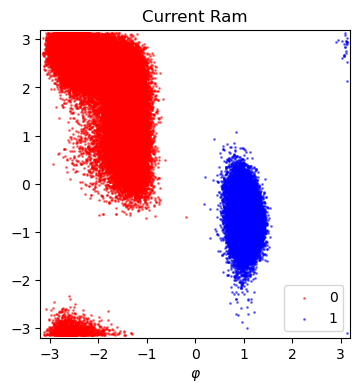

In [20]:
fig, ax = plt.subplots(figsize=(4, 4))
plot_range = [-3.2, 3.2]
color_map = ["red", "blue"]
for label in np.unique(label_list):
	idx = np.array(label_list) == label
	ax.scatter(np.array(phi)[idx], np.array(psi)[idx], color=color_map[label], s=1, label=label, alpha=0.5)
	# ax.scatter(np.array(phi)[~label_list], np.array(psi)[~label_list], color="blue", s=1, alpha=0.5)

ax.legend()
ax.set_xlim(-3.2, 3.2)
ax.set_ylim(-3.2, 3.2)
ax.set_title("Current Ram")
ax.set_xlabel(r"$\varphi$", fontsize=10)
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)